In [ ]:
#hide
from nbdev import *

In [ ]:
#hide
from hecss.core import *

# HECSS
> High Efficiency Configuration Space Sampler

HECSS is a Markow chain Monte-Carlo Metropolis-Hastings configuration space sampler. The theoretical foundation of the code are presented in the section `Background` below.

## Install

The HECSS package is avaliable on pypi and conda. Installation is simple just run:
```
pip install hecss
```
if you prefer pip as your package manager or:
```
conda install -c jochym hecss
```
if you prefer to use conda. The channel above will be changed to conda-forge at a later date.

## Update

For update just use your chosen package manager update function

## Usage

There are two main ways to use the library:
 * Use `hecss` library in your own python code. For this 
 *

Start by copying files from `example` subdirectory into `WORK` and following
the tutorial included there by opening `run_sampler.py` as Notebook.

# Background

The physical background of  HECSS is presented in [Jochym, Łażewski] which should be cited in every work using this code. Here is just a short overview of the foundations of the approach used in the code.



## General idea of HECSS

To reproduce the thermal equilibrium in the system, independent configurations of displacements consistent with a desired non-zero temperature should be selected. 
Having any initial approximations for the lattice dynamics of the system (e.g. standard harmonic approach) one can estimate temperature-dependent atomic mean-square-displacements (MSD) using a small set of force-displacement relations. Using these MSD data as a first approximation, the atomic displacements with normal distribution around equilibrium positions can be easily generated. 
There is, however, a subtle issue around displacements generated this way -- they are *uncorrelated* between atoms, while in reality atomic displacements are correlated at least for their close neighbours. For example, it is easy to see that a simultaneous out-of-phase movement of neighboring atoms towards or away from each other will generate larger changes in energy than a synchronous in-phase movement of the same atoms. The former configuration should be represented with lower probability than the later, instead of equal probability present in the above simplistic scheme. Thus, while the static configurations generation may be a correct direction in general, such a naive approach is not sufficient. 

One can see that some additional mechanism is required to adjust probability distribution of generated samples in order to accurately reproduce configurations drawn from thermodynamic equilibrium ensemble. Classical statistical mechanics points to such a scheme for selection of configurations representing a system in thermal equilibrium.

The general form of the equipartition theorem says that a generalized virial for any phase space coordinate (i.e. generalized coordinate or momentum) is proportional to temperature when it is averaged over the whole ensemble: 

$$
\left\langle x_m \frac{\partial H}{\partial x_n}\right\rangle = \delta_{mn}k_B T 
$$

If we assume ergodicity of the system, the ensemble average may be replaced with time average.
For momenta this leads to the average kinetic energy per degree of freedom being equal to $k_B T/2$ and provides the kinetic definition of temperature. However, the relation holds also for derivatives of Hamiltonian with respect to positions. Considering relation for some atomic displacement $q$ from the equilibrium configuration, and assuming the potential energy depends only on position, we can write position-dependent part of the Hamiltonian (i.e the potential energy $E_p(q)$) as a Taylor's expansion with respect to the atomic displacement $q$ from the equilibrium configuration:

$$
E_p(q) = \sum_{n=2}^{\infty} C_n q^n,
$$

where the expansion coefficients $C_n$ are, in general, functions of all remaining coordinates (displacements). 
The equipartition theorem now takes the form:

$$
k_B T = \left\langle q \sum_{n=2}^{\infty} n C_n q^{n-1} \right\rangle = \sum\limits_{n=2}^\infty n C_n \left\langle q^n \right\rangle
$$

and if we write $n$ as $(n-2)+2$ and divide both sides by $2$ we get:

$$
\left\langle E_p(q)\right\rangle = 
%\left\langle \sum_{n=2}^{\infty} C_n q^n \right\rangle = 
\frac{k_B T}{2} - 
    \sum\limits_{n=3}^\infty \frac{n-2}{2}C_n \left\langle q^n \right\rangle,
$$

which is similar to the kinetic energy counterpart except for an additional term generated by the anharmonic part of the potential and defined by the third and higher central moments of the probability distribution of the displacements. If we can assume that the second term is small in comparison with $k_B T$, we get a formula for the average potential energy of the system. Note that for harmonic systems the second part vanishes. For anharmonic systems omission of higher terms will provide first-order approximation of the mean potential energy. Only experience can tell us how good this approximation is and how wide its applicability range is. However, one should note that substantial higher-order terms are present only in parts of the formula connected with strongly anharmonic modes. Furthermore, for every atom in centro-symmetric position all odd-power moments vanish and the first non-zero moment is the fourth one. Finally, the formula for the potential energy of the whole system contains similar terms for all modes. Judging by extremely high efficiency of harmonic approximation for crystal lattice dynamics, we can expect that this averaging will make proposed approximation effective for a wide range of systems. 

To sum up, MD provides a representation of the system with the properly distributed kinetic energy. For a single particle it is a Maxwell-Boltzmann distribution. By virtue of the central limit theorem (CLT), if we increase the number of particles we will approach at infinity (i.e. in the thermodynamical limit) a Gaussian distribution with the same average (the same mean) and the variance which is scaled as inverse number of particles. As we can see for kinetic energy the relation is very simple whereas
for the potential energy we have a quantity approximately close to temperature if the system is not too far from a harmonic one. Nevertheless, we do not know, in general, the form of the distribution of the potential energy. That constitutes substantial difficulty, which fortunately can be overcome by application of the CLT to calculate distribution of potential energy.

The CLT states that for any reasonable probability distribution, the distribution of the mean of the sample of the independent random variable drawn from it tends to the normal distribution with the same mean and variance scaled by the square root of the number of samples. The *reasonable* class is very broad here, certainly containing all physically interesting cases by virtue of requiring a finite variance and a well-defined mean. Thus, for potential energy per degree of freedom we can expect the probability distribution to converge to the normal distribution:

$$
p(E_p) \xrightarrow[N\rightarrow\infty]{} \mathcal{N}(\langle E_p \rangle, \sigma/\sqrt{3N}).
$$

As shown above, one can approximate the $\langle E_p \rangle$ with the first term and the only unknown parameter in this formula is the variance of the distribution. Note that above expression is *independent* from the particular shape of the potential energy probability distribution for the single degree of freedom except of its mean $\langle E_p \rangle$ and variance $\sigma$.

However, we need to consider that the CLT is true *asymptotically*. At this point we need to decide if this relation has any practical use for *finite*, and preferably not too large, $N$? The common wisdom in statistical community states that for $N \gtrapprox 50$ the distribution of the average is practically indistinguishable from the true normal distribution, and even for smaller $N$ if the starting distribution is not too wild the convergence is usually very quick. 

## A very short example

Example taken from the `LAMMPS Tutorial` samples the thermodynamic distribution of 3C-SiC crystal at 300K. We start by importing required modules.

In [ ]:
from ase.build import bulk
from tqdm.auto import tqdm
import asap3
from hecss.monitor import plot_stats

Then we define the crystal and interaction model used in the calculation

In [ ]:
model = 'Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_003'

sys_size = '3x3x3'
sc = [int(v) for v in sys_size.split('x')]

cryst = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
cryst.set_calculator(asap3.OpenKIMcalculator(model))

Then we define the sampler parameters (N -- number of samples, T -- temperature) and run it.

In [ ]:
T = 300
N = 1_000
samples = [_ for _ in  HECSS_Sampler(cryst, asap3.OpenKIMcalculator(model), 
                                     T, N=N, pbar=tqdm(total=N))]

  0%|          | 0/1000 [00:00<?, ?it/s]

And finally we plot the histogram of the resulting energy distribution.

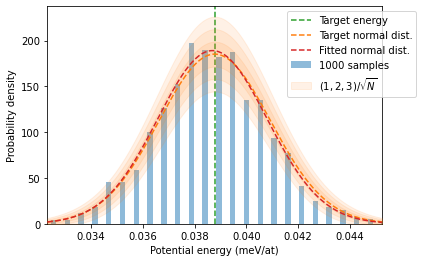

In [ ]:
plot_stats(samples, T)